In [1]:
import tensorflow as tf
from glob import glob #撈圖片(?
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image #用OPENCV 也OK
from sklearn.model_selection import train_test_split

#### Download dataset

In [2]:
!pip install --upgrade gdown #從雲端硬碟抓檔案
!gdown --fuzzy 1B6inr_JHXRTidFsSMqOGhJWJr_09hXdF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1B6inr_JHXRTidFsSMqOGhJWJr_09hXdF
To: /content/where_am_i.tar
100% 89.9M/89.9M [00:02<00:00, 35.7MB/s]


In [3]:
!tar xf where_am_i.tar
#載完資料要看看類別怎樣對應(mapping.txt)

#### Hyperparameters

In [4]:
IMG_SIZE = 224 #嘗試其他值也可以
BS = 64 

In [5]:
# 建立類別名稱轉class idx字典    (手KEY也OK，生的出這個字典就行)
with open("mapping.txt") as f:
    lines = f.readlines()
lines = [l.strip().replace(" ", "") for l in lines]
CLASS_MAP = {pair.split(",")[0]: int(pair.split(",")[1]) for pair in lines}
NUM_CLASS = len(CLASS_MAP) #有幾種類型

CLASS_MAP, NUM_CLASS
#也可以自己再做更多EDA

({'CALsuburb': 9,
  'PARoffice': 7,
  'bedroom': 12,
  'coast': 10,
  'forest': 4,
  'highway': 14,
  'industrial': 2,
  'insidecity': 3,
  'kitchen': 0,
  'livingroom': 5,
  'mountain': 8,
  'opencountry': 6,
  'store': 11,
  'street': 1,
  'tallbuilding': 13},
 15)

#### Build Dataset

In [6]:
# 撈取有解答之圖片路徑, 分割train, val路徑
paths = glob("train/*/*.jpg") #撈出TRAIN底下所有資料夾、所有JPG
train_paths, val_paths = train_test_split(paths, 
                                          test_size=0.2, 
                                          random_state=5566)

len(train_paths), len(val_paths)

(2152, 539)

((220, 293, 3), 'train/industrial/image_0158.jpg')

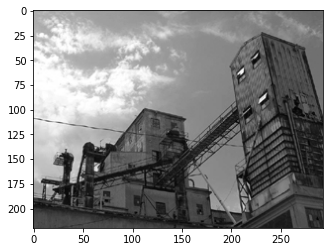

In [8]:
# 圖片視覺化
path = np.random.choice(train_paths) #隨機抽張圖來看看
img = np.array(Image.open(path).convert("RGB"))
plt.imshow(img)
img.shape, path

In [9]:
# 擷取資料夾名稱轉成類別id
#os.sep: "/"
def paths2labels(paths):
    return [CLASS_MAP[p.split(os.sep)[-2]] for p in paths] #path以"/"分割的倒數第二個就是類別名稱，在MAP查到他的數字

In [10]:
train_paths[:10], paths2labels(train_paths)[:10] #檢查

(['train/tallbuilding/image_0110.jpg',
  'train/PARoffice/image_0178.jpg',
  'train/insidecity/image_0151.jpg',
  'train/store/image_0270.jpg',
  'train/opencountry/image_0151.jpg',
  'train/livingroom/image_0034.jpg',
  'train/bedroom/image_0046.jpg',
  'train/opencountry/image_0003.jpg',
  'train/street/image_0150.jpg',
  'train/opencountry/image_0049.jpg'],
 [13, 7, 3, 11, 6, 5, 12, 6, 1, 6])

In [11]:
# 影像讀取 & resize
def load_and_resize_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

# 使用路徑建構 tf.data.Dataset
def build_ds(paths):
    labels = paths2labels(paths) # paths -> labels
    image_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_ds = image_ds.map(lambda path, label: (load_and_resize_image(path), label)) # path -> img, labels
    return image_ds

In [12]:
# 建構train, val dataset
train_ds = build_ds(train_paths).shuffle(buffer_size=len(train_paths)).batch(BS) #TRAINING才會做SHUFFLE
val_ds = build_ds(val_paths).batch(BS)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#### Build Model

In [13]:
class WAIModel(tf.keras.models.Model): #init和call一定要有
    def __init__(self, encoder, preprocess, freeze): #初始化
        super().__init__()
        # 前處理函數
        self.preprocess = preprocess
        # 資料擴增 (像這樣放模型裡也可以，外面另外做也可以)(可以再擴增更多)
        self.data_aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
        ])
        # feature extractor
        self.encoder = encoder
        # classifier
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(), #特徵圖轉為特徵向量
            tf.keras.layers.Dropout(0.2), #防OVERFITTING
            tf.keras.layers.Dense(NUM_CLASS), #分幾類(這裡15) #線性的
            tf.keras.layers.Softmax(), #多類分類用softmax
        ])
        # freeze: 是否鎖住encoder參數 (鎖著的話，等於只TRAIN最後的分類器)(比較不會OVERFITTING)
        if freeze:
            for l in self.encoder.layers:
                l.trainable = False
    def call(self, inputs, training=None): #有些網路層，訓練和預測時的行為不同，例如Dropout 
        x = self.preprocess(inputs)
        # 非訓練時不使用資料擴增
        if training:
            x = self.data_aug(x)
            
        x = self.encoder(x, training)
        x = self.classifier(x, training)
        return x
        #以上這CELL是繼承的寫法，要用FUNCTIONAL API(?)寫法也可以
        #TRANSFER LEARNING的強大
        #KERAS的很多模型都可以拿來用

In [14]:
# 使用模型對應之前處理函式
preprocess = tf.keras.applications.efficientnet.preprocess_input #用他分裝好了的前處理方式
encoder = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, #因為我們分類器是自己寫所以include_top=False
                                                            weights='imagenet') #用已訓練過的!

model = WAIModel(encoder, 
                 preprocess,
                 freeze=True)

16705208/16705208 [==============================] - 2s 0us/step


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #沒做One-Hot的話要加Sparse(模型會幫作One-Hot)
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

#### Training

In [16]:
model.fit(train_ds, 
          epochs=20, 
          validation_data=val_ds,
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint("best.h5",
                                                 save_best_only=True,
                                                 save_weights_only=True) #把模型的參數全都存下來
          ])

Epoch 1/20


34/34 [==============================] - 33s 445ms/step - loss: 1.7768 - sparse_categorical_accuracy: 0.5144 - val_loss: 0.9738 - val_sparse_categorical_accuracy: 0.8108
Epoch 2/20
34/34 [==============================] - 14s 361ms/step - loss: 0.8126 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.6008 - val_sparse_categorical_accuracy: 0.8497
Epoch 3/20
34/34 [==============================] - 14s 367ms/step - loss: 0.5594 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4759 - val_sparse_categorical_accuracy: 0.8683
Epoch 4/20
34/34 [==============================] - 14s 355ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.4130 - val_sparse_categorical_accuracy: 0.8813
Epoch 5/20
34/34 [==============================] - 14s 366ms/step - loss: 0.4003 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.8887
Epoch 6/20
34/34 [==============================] - 14s 354ms/step - loss: 0.3433 - sparse_categorical_acc

#### Test submission

繳交至：https://www.kaggle.com/competitions/aia-xt121-cv-kaggle

In [17]:
import pandas as pd

In [18]:
# 讀取最佳val_loss model參數
model.load_weights("best.h5")

In [19]:
df = pd.read_csv("sample_submission.csv")

In [20]:
df.head(), len(df)

(                     id  class
 0  12VJYE4AE85K3QZZIDGW      0
 1  4XLB86I30GZZZEVZBM2O      0
 2  TRS0Y4KQO74ET6A7POW8      0
 3  0R4BF4JPJL4QG25GNJRH      0
 4  YHQSSCEBEBB99DLIRTK8      0, 1794)

In [21]:
# 建構測試dataset
test_paths = [os.path.join(f"test/{name}.jpg") for name in df["id"].tolist()]
test_ds = tf.data.Dataset.from_tensor_slices((test_paths))
test_ds = test_ds.map(lambda path: load_and_resize_image(path)).batch(BS)

In [22]:
prediction = model.predict(test_ds)

29/29 [==============================] - 5s 115ms/step


In [23]:

prediction = np.argmax(prediction, axis=-1)

In [24]:
df["class"] = prediction

In [25]:
df.to_csv("submission.csv", index=None)

Public  Private

0.92264 0.90529